## Stream video data to the NN

In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

from __future__ import division
import rospy
import time
import os
import PIL
from IPython.display import clear_output
import matplotlib.pyplot as plt
from scipy import misc
import tensorflow as tf
import numpy as np
from deep_car.model import Model
from deep_car.data import get_steering_delta, get_steering_hist, continuous, crop_img
from PIL import ImageDraw, ImageFont, ImageFilter
from sensor_msgs.msg import CompressedImage
from std_msgs.msg import String,Int16
from io import BytesIO

In [2]:
rospy.init_node('PixelDriveNN')

# DistNN

This class is responsible for predicting the steering from pictures.
The predection is based on a neuronal network which is loaded when the class get initialised.

In [3]:
class DistNN:
    
    def __init__(self):
        gpu_options = tf.GPUOptions(allow_growth=True) 
        self.sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

        saver = tf.train.import_meta_graph('../data/steering_model/steering_mixture_prob_exp.ckpt.meta')
        saver.restore(self.sess, tf.train.latest_checkpoint('../data/steering_model/'))

        graph = tf.get_default_graph()

        self.x_img = graph.get_tensor_by_name("deep_car/image:0")
        self.steering_abs = graph.get_tensor_by_name("deep_car/steering_abs_true:0")
        self.steering_abs_pred = graph.get_tensor_by_name("deep_car/steering_abs_pred:0")
    
    def predictSteering(self,img):
        steering_pred_abs, = self.sess.run(
            [ self.steering_abs_pred], 
            feed_dict={
                self.x_img: img,
            }
        )
        return steering_pred_abs

nn = DistNN()

INFO:tensorflow:Restoring parameters from ../data/steering_model/steering_mixture_prob_exp.ckpt


In [5]:
def rad2deg(rad_value):
    return (rad_value + np.pi/2) / np.pi * 180

def deg2rad(deg_value):
    return deg_value/180.0 * np.pi - np.pi/2.0

# Car

This class represents the car and gives an interface for changing the speed and steering.
Also the callbacks for relevant ROS topics are defined in that class.
An instance of the neuronal network is created for every Car object and and used for making predections based
on the images from the front camera. 
The class also takes care of normalizing images for the neuronal network.

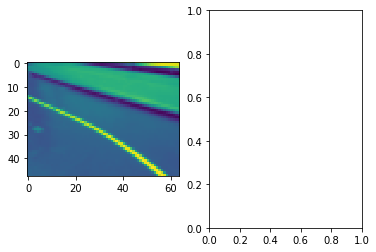

Speed : 0 | Steering : 62 | Last Action : 0
1455209017.65


In [6]:
class Car:

    def __init__(self):
        self.msg_timestamps = []
        self.speed = 0
        self.steering = 90
        self.current_steering = None
        self.crop_img = None
        self.driveNN = DistNN()
        self.dist_prob = None
        self.last_action = 0
        
        self.steering_pub = rospy.Publisher("/manual_control/steering", Int16, queue_size=10)
        self.speed_pub = rospy.Publisher("/manual_control/speed", Int16, queue_size=10)
        rospy.topics.Subscriber("/manual_control/speed", Int16, self.setSpeed)
        rospy.topics.Subscriber("/manual_control/steering", Int16, self.setSteering)
        rospy.topics.Subscriber("/deepcar/crop_img64x48/compressed", CompressedImage, self.processCropImg, queue_size=1)
        
    def setSpeed(self, speed):
        self.speed = speed.data
    
    def stop(self):
        self.pubSpeed(0)
    
    def driveSlow(self, direction=1):
        self.pubSpeed(direction * -150)
    
    def driveAverage(self, direction=1):
        self.pubSpeed(direction * -200)
    
    def driveFast(self, direction=1):
        self.pubSpeed(direction * -280)
    
    def setSteering(self, steering):
        self.steering = steering.data
    
    def processCropImg(self,msg):
        self.msg_timestamps.append(msg.header.stamp.to_sec())
        print(msg.header.stamp.to_sec())
        img_nn, img = self.extractImgFrom(msg)
        self.crop_img = img
        self.monitorCar()
        p_distr = self.updateSteering(img_nn)
    
    def updateSteering(self,img):
        steering = self.driveNN.predictSteering(img)
        deg_steering = rad2deg(-steering)
        self.pubSteering(deg_steering)
           
    def pubSteering(self, deg_value):
        self.steering_pub.publish(deg_value)
    
    def getNormSteering(self):
        return np.array([[self.steering / 180.0 * np.pi - np.pi/2]])
    
    def pubSpeed(self, speed):
        self.speed_pub.publish(speed)
    
    def extractImgFrom(self,msg):
        img_bytes = BytesIO(msg.data)
        img = PIL.Image.open(img_bytes)
        img = np.array(img)
        img_nn = img[np.newaxis,:,:,np.newaxis]
        return img_nn / (255/2.0) -1, img
    
    def monitorCar(self):
        clear_output(wait=True)
        fig,ax = plt.subplots(1,2)
        ax[0].imshow(self.crop_img)
        #self.plotPrediction(ax[1])
        plt.show()
        print("Speed : %d | Steering : %d | Last Action : %d" %(self.speed, self.steering, self.last_action))
        
    def plotPrediction(self,ax):
        if self.dist_prob is None:
            return
        ax.bar(np.arange(0, len(self.dist_prob[0])), np.exp(self.dist_prob[0]))
        ax.set_xlabel("distance")
        ax.set_ylabel("probability of steering")

    def hzFromHistory(self):
        if len(self.msg_timestamps)<22:
            return None
        delta_t = []
        for i in range(1,HISTORY_LENGTH+1):
            delta_t.append(float(self.msg_timestamps[-i]) - float(self.msg_timestamps[-(i+1)]))
        return sum(delta_t) / HISTORY_LENGTH

    def distPerMessage(self):
        return self.hzFromHistory() * self.speed

car = Car()

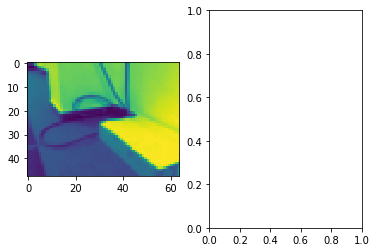

Speed : -150 | Steering : 115 | Last Action : 0
1455209341.87


In [17]:
car.pubSteering(90)
car.driveSlow()

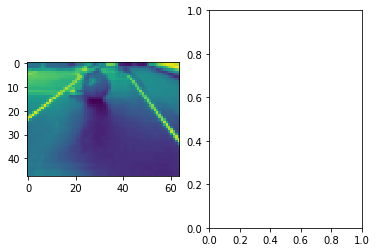

Speed : 0 | Steering : 91 | Last Action : 0


In [18]:
car.stop()

In [ ]:
rospy.spin()